# Load libraries & helper functions

In [1]:
%matplotlib inline
from helpers import *
# Turn interactive plotting off
plt.ioff()

# Declare parameters

In [2]:
config.DATADIR      = '/scratch/duboisjx/data/HCP/MRI'
#config.DATADIR      = '/home/duboisjx/mnt10/LabUsers/duboisjx/data/HCP/MRI'

# fMRI runs
# runs for which the FC will be averaged for each subject
fmriRuns      = ['rfMRI_REST1_LR','rfMRI_REST1_RL']

# use volume or surface data
config.isCifti      = False

config.overwrite    = False

config.pipelineName = 'Finn'
# use ICA-FIX input
config.useFIX       = False
config.preWhitening = False
config.Operations   = config.operationDict[config.pipelineName]

# submit jobs with sge
config.queue        = True
# make sure to set memory requirements according to data size
# 20G for HCP data!
config.maxvmem      = '21.5G'

# parcellation for FC matrix
config.parcellationName = 'shen2013'
config.parcellationFile = '/scratch/duboisjx/data/parcellations/shenetal_neuroimage2013_new/shen_3mm_268_parcellation.nii.gz'
#config.parcellationFile = '/home/duboisjx/mnt10/LabUsers/duboisjx/data/parcellations/shenetal_neuroimage2013_new/shen_2mm_268_parcellation.nii.gz'
config.nParcels         = 268

# subject selection parameters
#config.behavFile = '/home/duboisjx/mnt10/LabUsers/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_11_17_2015_0_47_11.csv'
config.behavFile = '/scratch/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_11_17_2015_0_47_11.csv'
config.release   = 'Q2'
config.outScore  = 'PMAT24_A_CR'

# Subject selection

Selected 125 from the release Q2
Number of males is: 40
Age range is 22 - 35
114924 : too much motion, exclude
123117 : too much motion, exclude
151223 : too much motion, exclude
156637 : too much motion, exclude
191437 : too much motion, exclude
199150 : too much motion, exclude
250427 : too much motion, exclude
298051 : too much motion, exclude
788876 : too much motion, exclude
937160 : too much motion, exclude


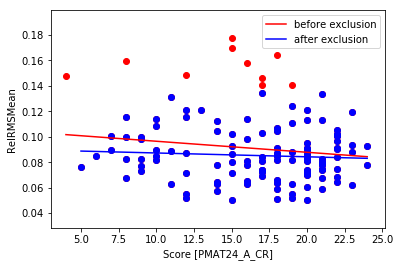

With all subjects: corr(IQ,motion) = -0.154 (p = 0.087)
After discarding high movers: corr(IQ,motion) = -0.073 (p = 0.441)
Keeping 115 subjects [36 M]


In [3]:
df = pd.read_csv(config.behavFile)
# select subjects according to release
if config.release == 'Q2':
    ind = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    ind = (df['Release'] != 'Q2') & (df['Release'] != 'Q1')
else:
    sys.exit("Invalid release code")
# select subjects that have completed all fMRI
ind = ind & ((df['fMRI_WM_Compl']== True) & (df['fMRI_Mot_Compl']==True) 
             & (df['fMRI_Lang_Compl']==True) & (df['fMRI_Emo_Compl']==True)         
             & (df['RS-fMRI_Count']==4))
df = df[ind]  
# check if either of the two subjects recommended for exclusion by HCP are still present
df = df[~df['Subject'].isin(['209733','528446'])]
df.index = range(df.shape[0])
tmpAgeRanges = sorted(df['Age'].unique())
# list of all selected subjects
subjects = df['Subject']
# pull their IQ, Age, Gender
age = df['Age']
gender = df['Gender']
score = df[config.outScore]

print 'Selected', str(df.shape[0]), 'from the release',config.release
print 'Number of males is:', df[df['Gender']=='M'].shape[0]
print 'Age range is', tmpAgeRanges[0].split('-')[0], '-', tmpAgeRanges[-1].split('-')[1]

# Exclusion of high-motion subjects
# exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)
subjects   = [str(subject) for subject in subjects]
RelRMSMean = np.zeros([len(subjects), len(fmriRuns)],dtype=np.float32)
compSub    = np.zeros((len(subjects)),dtype=np.bool_)
keepSub    = np.zeros((len(subjects)),dtype=np.bool_)
iSub=0
for config.subject in subjects:
    i=0
    for config.fmriRun in fmriRuns:
        RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
        #print RelRMSMeanFile
        if op.isfile(RelRMSMeanFile):
            with open(RelRMSMeanFile,'r') as tmp:
                RelRMSMean[iSub,i] = float(tmp.read())
        else:
            print RelRMSMeanFile+' File missing'
            break
        i=i+1
    if i==len(fmriRuns): # all RelRMSMeanFile exist
        compSub[iSub]=True
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            print config.subject, ': too much motion, exclude'
        else:
            keepSub[iSub]=True
    iSub=iSub+1

#### motion vs. score correlation
plt.scatter(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1),c='r')
plt.scatter(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1),c='b')
# fit a curve to the data using a least squares 1st order polynomial fit
z1 = np.polyfit(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1),1)
z2 = np.polyfit(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1),1)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)                
fit1 = p1(score[keepSub])
fit2 = p2(score[compSub])
# get the coordinates for the fit curve
c1_x = [np.min(score[keepSub]),np.max(score[keepSub])]
c1_y = p1(c1_x)
c2_x = [np.min(score[compSub]),np.max(score[compSub])]
c2_y = p2(c2_x)
# plot line of best fit
plt.plot(c2_x,c2_y,'r-',label='before exclusion')
plt.plot(c1_x,c1_y,'b-',label='after exclusion')
plt.xlabel('Score [{}]'.format(config.outScore))
plt.ylabel('RelRMSMean')
plt.legend(loc=0)
plt.show()
rho1,p1 = stats.pearsonr(score[keepSub],np.mean(RelRMSMean[keepSub,:],axis=1))
rho2,p2 = stats.pearsonr(score[compSub],np.mean(RelRMSMean[compSub,:],axis=1))            
print 'With all subjects: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho2,p2)
print 'After discarding high movers: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho1,p1)
    
subjects   = [subject for (subject, keep) in zip(subjects, keepSub) if keep]
age        = age[keepSub]
gender     = gender[keepSub]
score      = score[keepSub]
RelRMSMean = RelRMSMean[keepSub,:]
print 'Keeping {} subjects [{} M]'.format(len(subjects),sum([g=='M' for g in gender]))

# Do work

### preprocess everybody

In [ ]:
keepSub = np.zeros((len(subjects)),dtype=np.bool_)
iSub=0
displayPlot=False
for config.subject in subjects:
    iRun = 0
    for config.fmriRun in fmriRuns:
        if not config.queue:
            print 'SUB {}/{} [{}]: run {}/{} [{}]'.format(iSub+1,len(subjects),config.subject,iRun+1,len(fmriRuns),config.fmriRun)
        keepSub[iSub] = runPipelinePar()
        if not keepSub[iSub]:
            break
        iRun=iRun+1
    iSub = iSub + 1
print 'Keeping {}/{} subjects'.format(np.sum(keepSub),len(subjects))

if config.queue:
    if len(config.joblist) != 0:
        while True:
            nleft = len(config.joblist)
            for i in range(nleft):
                myCmd = "qstat | grep ' {} '".format(config.joblist[i])
                isEmpty = False
                try:
                    cmdOut = check_output(myCmd, shell=True)
                except CalledProcessError as e:
                    isEmpty = True
                finally:
                    if isEmpty:
                        nleft = nleft-1
            if nleft == 0:
                break
            else:
                print 'Waiting for {} subjects to complete...'.format(nleft)
            sleep(10)
    print 'All done!!'

Keeping 115/115 subjects
Waiting for 197 subjects to complete...
Waiting for 194 subjects to complete...
Waiting for 177 subjects to complete...
Waiting for 176 subjects to complete...
Waiting for 171 subjects to complete...
Waiting for 171 subjects to complete...
Waiting for 164 subjects to complete...
Waiting for 163 subjects to complete...
Waiting for 160 subjects to complete...
Waiting for 159 subjects to complete...
Waiting for 156 subjects to complete...
Waiting for 153 subjects to complete...
Waiting for 148 subjects to complete...
Waiting for 145 subjects to complete...
Waiting for 142 subjects to complete...
Waiting for 138 subjects to complete...
Waiting for 137 subjects to complete...
Waiting for 137 subjects to complete...
Waiting for 137 subjects to complete...
Waiting for 137 subjects to complete...
Waiting for 136 subjects to complete...
Waiting for 134 subjects to complete...
Waiting for 133 subjects to complete...
Waiting for 130 subjects to complete...
Waiting for 127

### look at QC

In [ ]:
fdScores     = np.zeros((len(subjects),len(fmriRuns)),dtype=np.float32)
fcMats       = np.zeros((config.nParcels,config.nParcels,len(subjects),len(fmriRuns)),dtype=np.float32)
fcMats_dn    = np.zeros((config.nParcels,config.nParcels,len(subjects),len(fmriRuns)),dtype=np.float32)
displayPlot  =False
config.queue =False
iSub= 0
for config.subject in subjects:
    if keepSub[iSub]:
        print 'SUB {}/{}: {}'.format(i+1,len(subjects),config.subject)
        iRun = 0
        for config.fmriRun in fmriRuns:
            runPipelinePar()
            fcMats[:,:,iSub,iRun],fcMats_dn[:,:,iSub,iRun] = plotFC(displayPlot)
            fdScores[iSub,iRun]=np.mean(computeFD())
            iRun = iRun+1
    iSub = iSub + 1

fdScores  = np.squeeze(np.mean(fdScores[keepSub,:],1))
fcMats    = np.squeeze(np.tanh(np.mean(np.arctanh(fcMats[:,:,keepSub,:]),3)))
fcMats_dn = np.squeeze(np.tanh(np.mean(np.arctanh(fcMats_dn[:,:,keepSub,:]),3)))

scores    = scores[keepSub]

# rsFC/mean FD plot
# since this is a correlation across subjects, it makes most sense if we have enough subjects
if len(subjects)>20:    
    plotQCrsFC(fcMats,fcMats_dn,fdScores)
    
# deltaR plot
plotDeltaR(fcMats,fcMats_dn)

# IQ prediction

In [ ]:
# threshold for feature selection
thresh = 0.01

n_subs  = np.sum(keepSub)
n_nodes = config.nParcels

behav_pred_pos = np.zeros([n_subs,1])
behav_pred_neg = np.zeros([n_subs,1])

triu_idx = np.triu_indices(n_nodes,1)
n_edges = len(triu_idx[1]);
edges = np.zeros([n_subs,n_edges])
for iSub in range(n_subs):
    edges[iSub,] = fcMats_dn[:,:,iSub][triu_idx]

loo = cross_validation.LeaveOneOut(n_subs)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subs,1])
errors_neg = np.zeros([n_subs,1])
predictions_pos = np.zeros([n_subs,1])
predictions_neg = np.zeros([n_subs,1])

p=0.01
i=0
for train_index, test_index in loo:
    pears = [stats.pearsonr(np.squeeze(edges[train_index,j]),scores[train_index]) for j in range(0,n_edges)]
    # select edges (positively and negatively) correlated with gF with threshold p
    idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
    idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
    filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
    filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
    # compute network statistic for each subject in training
    strength_pos = filtered_pos.sum(axis=1) 
    strength_neg = filtered_neg.sum(axis=1)
    # compute network statistic for test subject
    str_pos_test = edges[test_index,idx_filtered_pos].sum()
    str_neg_test = edges[test_index,idx_filtered_neg].sum()
    # regression
    lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
    predictions_pos[i] = lr_pos.predict(str_pos_test)
    lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
    predictions_neg[i] = lr_neg.predict(str_neg_test) 
    errors_pos[i] = abs(predictions_pos[i]-gF[test_index])
    errors_neg[i] = abs(predictions_neg[i]-gF[test_index])
    i=i+1

# plot
x = np.ravel(score)
fig = plt.figure(figsize=(10,20))
ax1 = plt.subplot(121)
y = np.ravel(predictions_pos)
plot_corrs(x,y)
ax2 = plt.subplot(122)
y = np.ravel(predictions_neg)
plot_corrs(x,y)
